In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import gc

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from utils import *
from deep_prior_networks import *
import tensorflow.keras.backend as K
from glob import glob
import sigpy as sp
import sigpy.mri as mri
import ipdb
import utils2
import cv2
import h5py    
import numpy as np    


C:\Users\kushg\.conda\envs\cs285_env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kushg\.conda\envs\cs285_env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kushg\.conda\envs\cs285_env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kushg\.conda\envs\cs285_env\lib\site-packages\tensorflow\pyth

In [158]:

img  = 0
myMask = 12
with h5py.File("singlecoil_challenge/singlecoil_challenge.hdf5", 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    img = np.fft.fftshift(np.fft.ifftn(f["kspace"][12]))
    myMask = list(f["mask"])  

Keys: <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'mask']>


C:\Users\kushg\.conda\envs\cs285_env\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [155]:
len(myMask)
mask = np.zeros(img.shape)
mask= mask.T
for i in range(len(mask)):
    mask[i] = np.ones(len(mask[0])) * myMask[i]
mask= mask.T
#mask = np.fft.fftshift(mask)

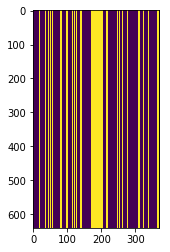

In [140]:
plt.imshow(np.abs(mask))

In [20]:
def recon_loss_L1_2chan_fixed3(y_true, y_pred):
    y_pred = tf.cast(tf.squeeze(y_pred, axis=0), dtype=tf.complex64)
    fft_img = tf.fft2d(y_pred[:, :, 0] + 1j*y_pred[:, :, 1])
    masked = tf.multiply(fft_img, mask)
    ifft = tf.ifft2d(masked)    
    squeeze_ytrue =tf.cast( tf.squeeze(y_true, axis=0) , dtype=tf.complex64)

    #New conjugate loss function
    imag_ytrue = squeeze_ytrue[: ,: , 0] + 1j * squeeze_ytrue[: ,: , 1]
    subtract = tf.cast(ifft - imag_ytrue , tf.complex64)
    conj = tf.cast(tf.real(subtract), dtype=tf.complex64) -  1j * tf.cast(tf.imag(subtract), dtype=tf.complex64)
    loss = tf.sqrt(tf.real(tf.multiply(subtract , conj)))
    
    loss = tf.reduce_sum(loss)
    
    print("ifft" , ifft.shape)
    print("imag_ytrue" , imag_ytrue.shape)
    print("squeeze_ytrue" , squeeze_ytrue.shape)
    print("loss" , loss.shape)
    
    return loss

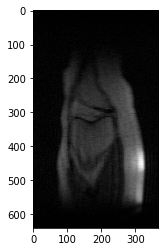

In [110]:
plt.imshow(np.sqrt(normalized_img[0 , :, : , 0] ** 2 + normalized_img[0 , :, : , 1] ** 2) , cmap = 'gray' )

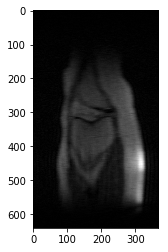

In [135]:
plt.imshow(np.sqrt(out[ :, : , 0] ** 2 + out[ :, : , 1] ** 2) , cmap = 'gray' )

start 1
ifft (640, 368)
imag_ytrue (?, ?)
squeeze_ytrue (?, ?, ?)
loss ()


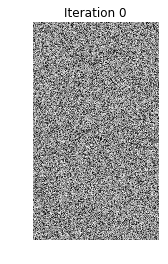

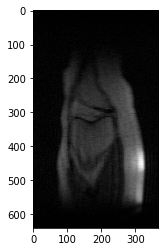

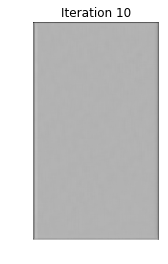

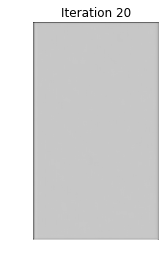

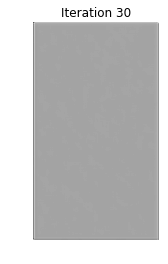

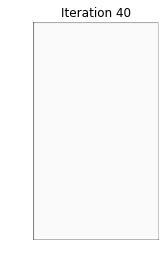

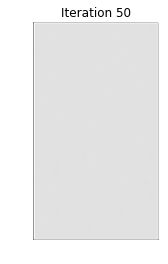

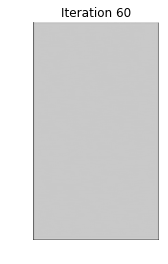

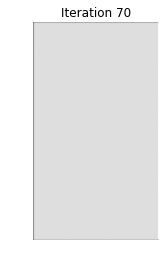

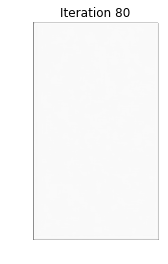

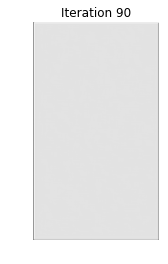

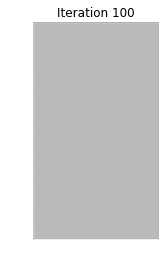

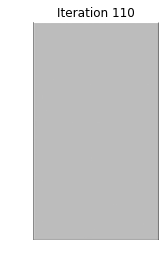

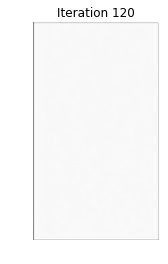

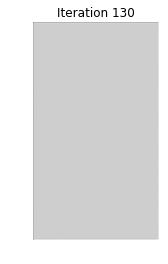

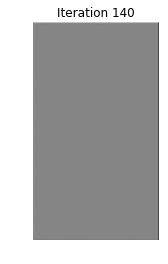

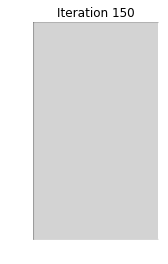

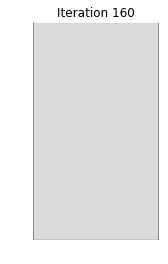

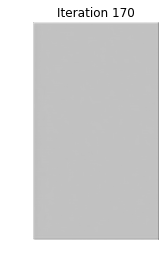

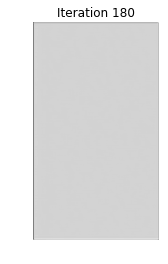

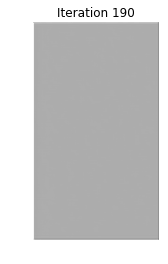

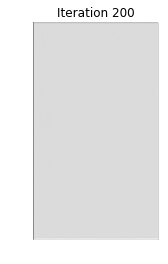

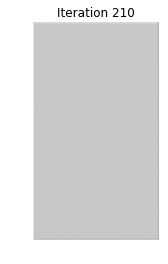

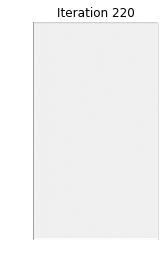

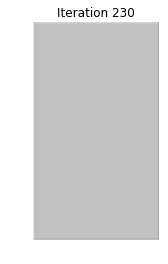

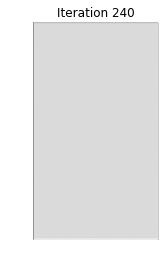

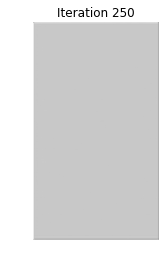

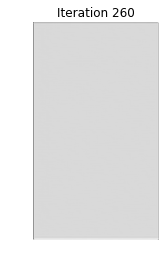

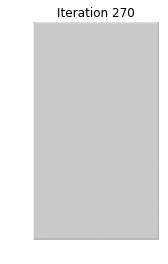

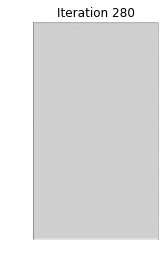

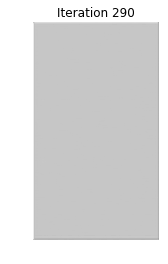

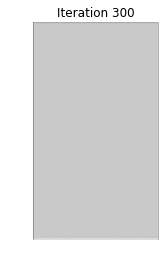

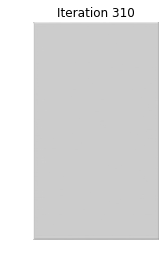

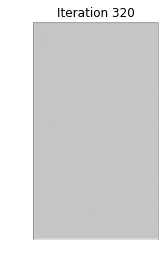

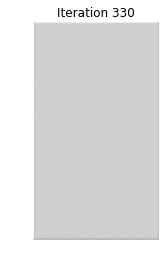

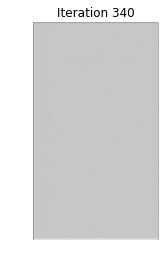

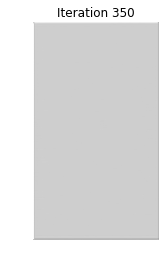

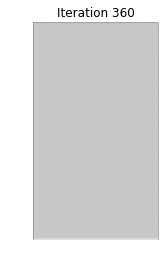

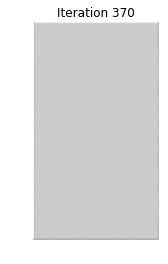

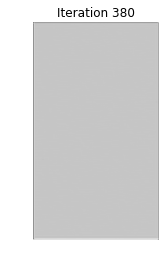

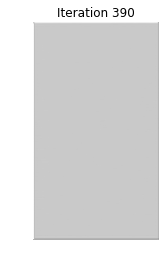

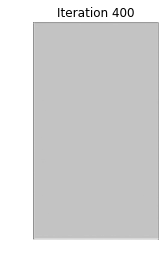

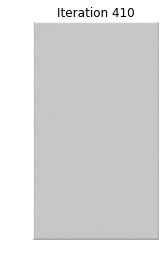

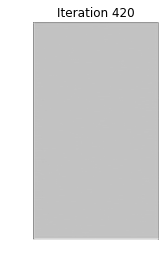

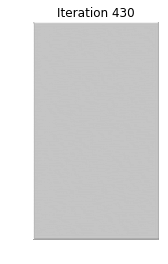

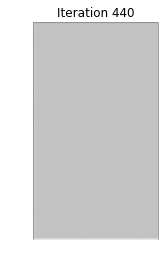

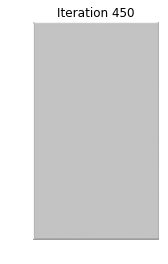

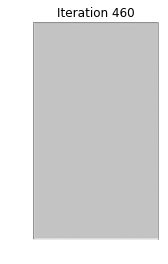

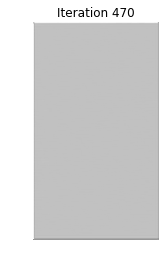

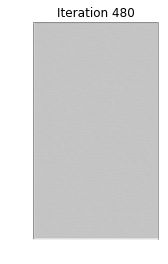

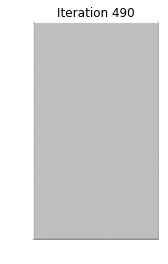

KeyboardInterrupt: 

In [99]:
normalized_img = np.zeros((640, 368, 2))
normalized_img[: , :, 0] = np.real(img)[: , :368]
normalized_img[: , :, 1] = np.imag(img)[: , :368]

normalized_img = np.array([normalized_img])


mask = myMask.astype(complex)[: , :368]
trials = 1
all_results = [] # same image, diff image, 2 diff, 4 diff
for i in range(trials):
    
    epochs = 10
    iters = 250
 
    batch_size = 1
    print('start 1')
        
    noisy = np.random.random(size=normalized_img.shape[1:]) * 2 - 1
    test_noise = np.random.random(size=normalized_img.shape[1:]) * 2 - 1
    noise = np.array([noisy for _ in range(batch_size)])
    jit_sched = [0.1 if k < iters // 2 else 0.01 for k in range(iters)]


    
    
    autoencoder = define_network_6_2chan(verbose=False)
    
    autoencoder.compile(Adam(1e-3), loss = recon_loss_L1_2chan_fixed3)
    results, losses, new_noise = train_network_2chan(autoencoder, noise, normalized_img, epochs, iters, jitter_schedule=jit_sched, plot=True, batch_size=batch_size)
    all_results.append(losses)

    del autoencoder
    gc.collect()

#     print("start 2")
#     noise = np.array([noisy for _ in range(batch_size)])
#     jit_sched = [0.1 if k < iters // 2 else 0.01 for k in range(iters)]
    
#     normalized_img = get_batch_normalized_2chan([100])
#     normalized_new_img = get_subsampled_normalized_2chan(get_image_normalized_2chan(100), 4)
#     autoencoder = define_network_4_2chan(verbose=False)
#     autoencoder.compile(Adam(1e-3), loss = recon_loss_L2_2chan_fixed3 )
#     results, losses, new_noise = train_network_2chan(autoencoder, noise, normalized_img, epochs, iters, normalized_img, [L1_loss, L2_loss], jitter_schedule=jit_sched, plot=False, batch_size=batch_size)
#     all_results.append(losses)
    
#     del autoencoder
#     gc.collect()

In [98]:
def train_network_2chan(network, noise, y, epochs, iterations, jitter_schedule = [0], plot=False, batch_size=1 , exp_name="test"):
    #base_image = np.expand_dims(noise, 0) 
    base_image = np.expand_dims(noise, 0) if np.shape(noise)[0] > 1 else noise
    y_image = np.expand_dims(y, 0) if np.shape(noise)[0] > 1 else y
    fit_params = {
        'x': base_image,
        'y': y_image, 
        'epochs': epochs,
        'batch_size': batch_size,
        'verbose': 0
    }
    
    if plot:
        plt.axis('off')
        plt.title('Iteration 0')
        plt.imshow(np.sqrt(base_image[0, :, :, 0]**2 + base_image[0, :, :, 1]**2), cmap='gray')
        plt.show()
        plt.imshow(np.sqrt(y_image[0, :, :, 0]**2 + y_image[0, :, :, 1]**2), cmap='gray')
        plt.show()
        
    results = np.empty(base_image.shape)
    #all_losses = [[] for _ in range(len(losses))]
    
    if len(jitter_schedule) == 1:
        jitter = jitter_schedule[0]
        jitter_schedule = [jitter] * iterations

    noise_size = y.shape
    for i in range(iterations):
        fit_params['x'] += jitter_schedule[i] * (np.random.random(size = noise_size) * 2 - 1) #(1, ) + np.shape(noise)
        network.fit(**fit_params)
        output = network.predict(base_image)
        results = np.append(results, output, axis=0)
        
        #print(all_losses[-1][-1])
        if plot:
            plt.axis('off')
            plt.title('Iteration '+ str((i+1)*fit_params['epochs']))
            plt.imshow(-np.sqrt(output[0][:, :, 0] ** 2 + output[0][:, :, 1] ** 2), cmap='gray')
            plt.show()
            if(i >= iterations - 1):
                np.save("./run_data/" + exp_name , output)
            #get_subsampled_normalized_2chan2( output[0] , mask , True)
            
            
            
            plt.show()
        
    return results, fit_params['x']

In [89]:
def define_network_6_2chan(verbose=False):
    autoencoder = Sequential([
        Convolution2D(8, 3, padding = 'same', input_shape = (640,368, 2)), 
        MaxPooling2D(padding='same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1),
        Activation('relu'), 
        Convolution2D(8, 3, padding = 'same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1), #Activation('relu'), 
        Activation('relu'), 
        Convolution2D(16, 3, padding = 'same'),
        MaxPooling2D(padding='same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1), #Activation('relu'), 
        Activation('relu'), 
        Convolution2D(16, 3, padding = 'same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1), #Activation('relu'),
        Activation('relu'), 
        Convolution2D(32, 3, padding = 'same'),
        MaxPooling2D(padding='same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1), #Activation('relu'),
        Activation('relu'), 
        Convolution2D(32, 3, padding = 'same'),
        Activation('relu'), 
        Convolution2D(64, 3, padding = 'same'),   
        MaxPooling2D(padding='same'),
        Activation('relu'), 
        Convolution2D(64, 3, padding = 'same'),   
        Activation('relu'), 
        Flatten(),
        Dense(((640 // (2**4)) * (368 // (2**4)) * 2), activation = 'tanh'),
        Reshape(((640 // (2**4)), (368 // (2**4)), 2)),
        Convolution2D(128, 3, padding = 'same'),
        Activation('relu'), 
        Convolution2D(128, 1, padding = 'same'),
        Activation('relu'), 
        UpSampling2D(),
        Convolution2D(64, 3, padding = 'same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1), #Activation('relu'),
        Activation('relu'), 
        Convolution2D(64, 1, padding = 'same'),
        Activation('relu'), 
        UpSampling2D(),
        #BatchNormalization(),
        Convolution2D(32, 3, padding = 'same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1), #Activation('relu'),
        Activation('relu'), 
        Convolution2D(32, 1, padding = 'same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1), #Activation('relu'),
        Activation('relu'), 
        UpSampling2D(),
        #BatchNormalization(),
        Convolution2D(16, 3, padding = 'same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1), #Activation('relu'),
        Activation('relu'), 
        Convolution2D(16, 1, padding = 'same'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.1), #Activation('relu'),
        Activation('relu'), 
        UpSampling2D(),
        #BatchNormalization(),
        Convolution2D(2, 3, padding = 'same'),
        #BatchNormalization(),
        Activation('tanh')
    ])
    if verbose:
        print(autoencoder.summary())
    return autoencoder